In [1]:
# Import relevant libraries
from astropy.stats import sigma_clipped_stats
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits,ascii
from astropy.visualization import simple_norm  # this will come in handy to visualize images
import sep
from matplotlib.patches import Ellipse, Circle
from matplotlib.backends.backend_pdf import PdfPages
from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord,match_coordinates_sky
import General_functions as my
import scipy.stats as stats

# Useful Functions

Lets define some useful functions to create load images, map background, extract sources, define apertures, and plot cutouts of a few objects in the different bands: g, i, IR and a stacked image of the three.

In [2]:
# For loading images
def open_img(filename, hdu=0):
    
    if filename[-5:] == '.fits':  
        # if last 5 characters of the string are '.fits', the file is interpreted as FITS file
        hdul = fits.open(filename)  # open the HDU list of a FITS file 
                                    # (it may contain multiple data sets called Header Data Units)
            
        img = hdul[hdu].data  # save data from the unit n. 1 (or whatever is the `hdu` nuber) into `img` array
        hdr = hdul.info()  # we may need also the header, which contain info about the image/data set
        # .header
        hdul.close()  # close the FITS file
        
    else:
        # if not FITS file, the function complains because it doesn't know other ways to do
        sys.exit("ERROR: open_img can deal with FITS file only.")
        
    return img, hdr  # the output is a tuple of two different objects

In [3]:
# For visualising the images before manipulating them
def img_plot(img, ax, title=None):
    
    #Normalise
    normal = simple_norm(img,stretch='sqrt', percent=99.5)
    
    # Plot
    ax.imshow(img, cmap='gray', origin='lower', norm=normal)
    ax.set_title(title)

In [4]:
# For mapping the background and subtracting it from the image
def bkg_subtract(img, plot=True):
    
    # Byteswap
    img = img.byteswap(inplace=True).newbyteorder()
    
    # Get background
    bkg = sep.Background(img, bw=1000, bh=1000, fw=4, fh=4)
    
    # Plot bkg and bkg rms
    if plot:
        fig, ax = plt.subplots(ncols=2, figsize=(12,6))
    
        ax[0].imshow(bkg.back(), interpolation='nearest', cmap='gray', origin='lower')
        ax[0].set_title('Background')
    
        ax[1].imshow(bkg.rms(), interpolation='nearest', cmap='gray', origin='lower')
        ax[1].set_title('Background RMS')
    
    return img - bkg, img, bkg

In [5]:
# Plotting ALL found objects, marked by ellipses
def objects_plotter(img_sub, objects, ax, title=None):
    
    # Normalise
    normal = simple_norm(img_sub, stretch='sqrt', percent=99.5)

    # Display image
    ax.imshow(img_sub, cmap='gray', origin='lower', norm=normal)
    ax.set_title(title)
    
    # Mark objects (takes time!)
    for i in range(len(objects)):
        e = Ellipse(xy=(objects['x'][i], objects['y'][i]), width=6*objects['a'][i],
                height=6*objects['b'][i], angle=i_objects['theta'][i] * 180. / np.pi)
        e.set_facecolor('none')
        e.set_edgecolor('red')
        ax.add_artist(e)

In [6]:
# Plotting found objects in a specified zoom window
def objects_zoom_plotter(img_sub, objects, ax, xrange=(0,400), yrange=(0,400), title=None):
    
    # Extract coordinates for zoom window
    xmin, xmax = xrange[0], xrange[1]
    ymin, ymax = yrange[0], yrange[1]
    
    # Get mask identifying objects within window
    s = (objects['x']>xmin) & (objects['x']<xmax) & (objects['y']>ymin) & (objects['y']<ymax)
    
    # Get coordinates and radius
    coord = list( zip( objects['x'][s], objects['y'][s] ) )
    r = ((objects['xmax'][s]-objects['xmin'][s])/2 + (objects['ymax'][s]-objects['ymin'][s])/2)/2
    
    # Normalise and plot
    normal = simple_norm(img_sub[xmin:xmax, ymin:ymax], stretch='sqrt', percent=99.5)
    ax.imshow(img_sub, cmap='gray', origin='lower', norm=normal)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(title)
    
    # Mark objects
    for i in range(len(coord)):
        c = Circle(xy=coord[i], radius = r[i])
        c.set_facecolor('none')
        c.set_edgecolor('red')
        ax.add_artist(c)

In [7]:
# Integrate flux, and plot histogram
def find_flux(img_sub, objects, bkg, title=None):
    
    # Calculate radius
    r = ((objects['xmax']-objects['xmin'])/2 + (objects['ymax']-objects['ymin'])/2)/2
    
    # Calculate flux
    flux, fluxerr, flag = sep.sum_circle(img_sub, objects['x'], objects['y'], r, err=bkg.rms(), gain=1.0)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_title(title)
    
    # Plot image flux
    ax.hist(img_sub.flatten(), range=(-10,300), bins=50, histtype='step', color='blue', linewidth=2, label='all pixels in the image (bkg subtracted)')

    ax.set_ylabel('N. of pixels / N. of stars', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.legend(loc='upper left')

    # Plot peak flux of stars
    ax2 = ax.twinx()
    ax2.hist(flux, range=(-10,300), bins=50, histtype='step', color='red', linewidth=2, label='flux peak of stars')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='upper right')

    # Set labels etc
    ax.set_xlabel('Flux [native units]')   # always define the axis labels
    ax2.set_ylabel('N. of pixels / N. of stars', color='red')

    print('Mean flux:', np.mean(flux), 'Median flux:', np.median(flux))

    return flux, fluxerr

# Loading images and visualising them

In [8]:
g_img, g_header = open_img('Resources/HSC_G_SSP_PDR2_CANDELS.fits', hdu=0)
print(g_header)

i_img, i_header = open_img('Resources/HSC_i_SSP_PDR2_19_07_19_v3_CANDELS.fits', hdu=0)
print(i_header)

IR_img, IR_header = open_img('Resources/UVISTA_Ks_19_11_18_allpaw_skysub_015_dr4_rc_v2_CANDELS.fits', hdu=0)
print(IR_header)

Filename: Resources/HSC_G_SSP_PDR2_CANDELS.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   (6000, 8000)   float32   
None
Filename: Resources/HSC_i_SSP_PDR2_19_07_19_v3_CANDELS.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   (6000, 8000)   float32   
None
Filename: Resources/UVISTA_Ks_19_11_18_allpaw_skysub_015_dr4_rc_v2_CANDELS.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   (6000, 8000)   float32   
None


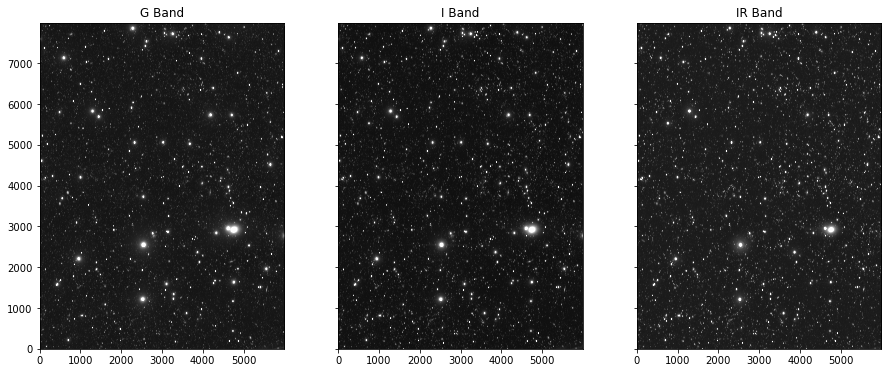

In [9]:
# Lets plot the files
fig, ax = plt.subplots(ncols=3, figsize=(16,6), gridspec_kw = {'wspace': 0.01}, sharey=True)

img_plot(g_img, ax[0], title='G Band')
img_plot(i_img, ax[1], title='I Band')
img_plot(IR_img, ax[2], title='IR Band')

# Background Subtraction

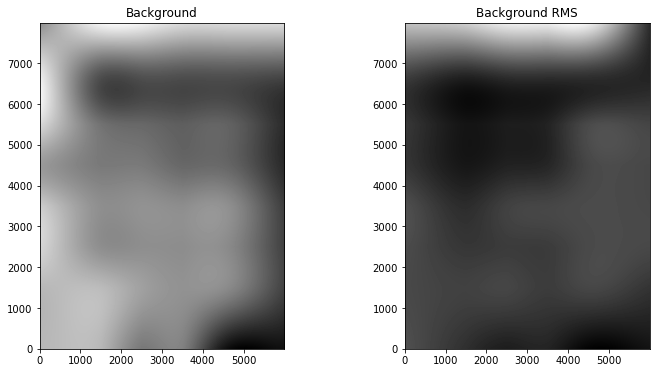

In [10]:
g_clean, g_img, g_bkg = bkg_subtract(g_img, plot=True)

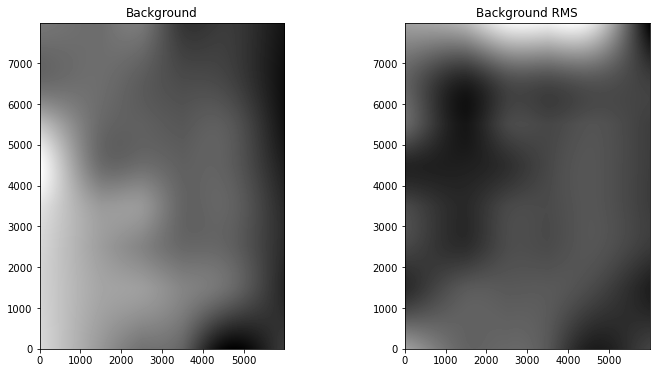

In [11]:
i_clean, i_img, i_bkg = bkg_subtract(i_img, plot=True)

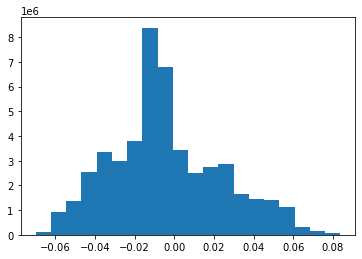

In [13]:
plt.hist(i_bkg.back().flatten(), bins=20)
plt.show()

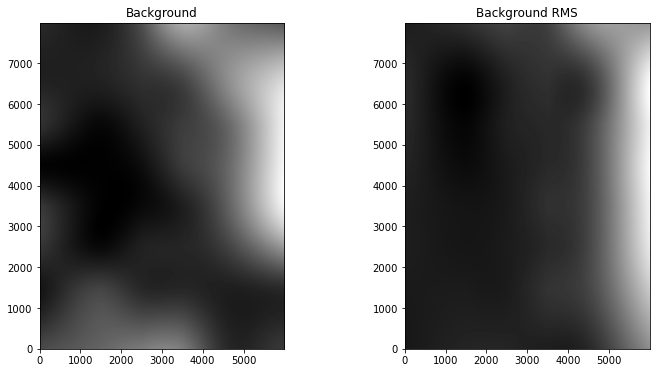

In [14]:
IR_clean, IR_img, IR_bkg = bkg_subtract(IR_img, plot=True)

# Object Detection

In [15]:
g_objects = sep.extract(g_clean, 10, err=g_bkg.globalrms)
len(g_objects)

11853

In [16]:
i_objects = sep.extract(i_clean, 10, err=i_bkg.globalrms)
len(i_objects)

16480

In [17]:
IR_objects = sep.extract(IR_clean, 10, err=IR_bkg.globalrms)
len(IR_objects)

10903

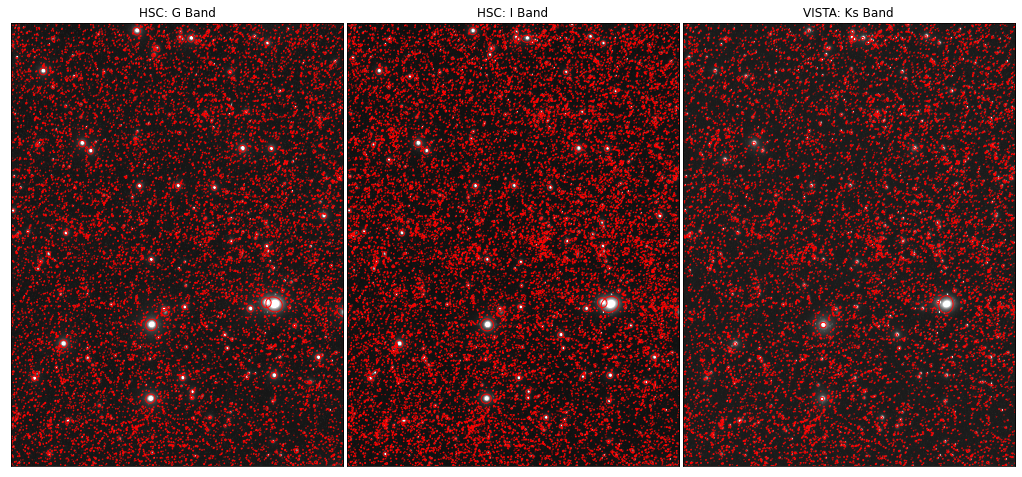

In [26]:
# Takes quite a while (circa 3mins), okay to skip, only for illustrative purposes
fig, ax = plt.subplots(ncols=3, figsize=(18, 10), gridspec_kw={'wspace':0.01})
ax[0].set(xticks=([]), yticks=([]))
ax[1].set(xticks=([]), yticks=([]))
ax[2].set(xticks=([]), yticks=([]))
objects_plotter(g_clean, g_objects, ax[0], title='HSC: G Band')
objects_plotter(i_clean, i_objects, ax[1], title='HSC: I Band')
objects_plotter(IR_clean, IR_objects, ax[2], title='VISTA: Ks Band')

# Save figure 
plt.savefig('Saved_Figures/Source_Detection_Results.pdf', facecolor='w')

# Aperture Photometry with Variant Aperture Radius

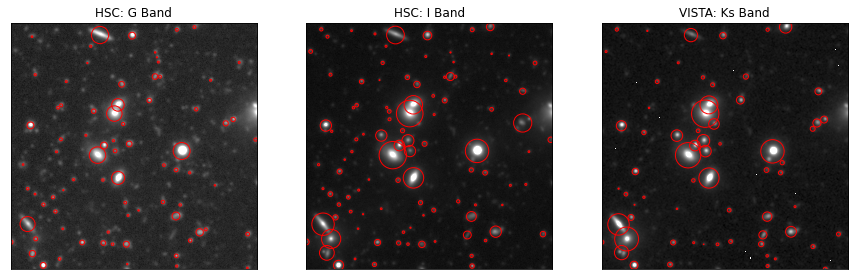

In [28]:
# Show zoom windows, so we can see the variant apertures we will use
fig, ax = plt.subplots(ncols=3, figsize=(15, 8))

x1, x2 = 500, 1000
y1, y2 = 500, 1000

objects_zoom_plotter(g_clean, g_objects, ax[0], xrange=(x1,x2), yrange=(y1,y2), title='HSC: G Band')
objects_zoom_plotter(i_clean, i_objects, ax[1], xrange=(x1,x2), yrange=(y1,y2), title='HSC: I Band')
objects_zoom_plotter(IR_clean, IR_objects, ax[2], xrange=(x1,x2), yrange=(y1,y2), title='VISTA: Ks Band')

ax[0].set(xticks=([]), yticks=([]))
ax[1].set(xticks=([]), yticks=([]))
ax[2].set(xticks=([]), yticks=([]))

# Save figure
plt.savefig('Saved_Figures/Source_Detection_Zoom.pdf', facecolor='w')

Mean flux: 6063.057798450635 Median flux: 201.38783525466917
Mean flux: 8899.704506673956 Median flux: 356.61312597274787
Mean flux: 14907.524741504758 Median flux: 600.5876703453066


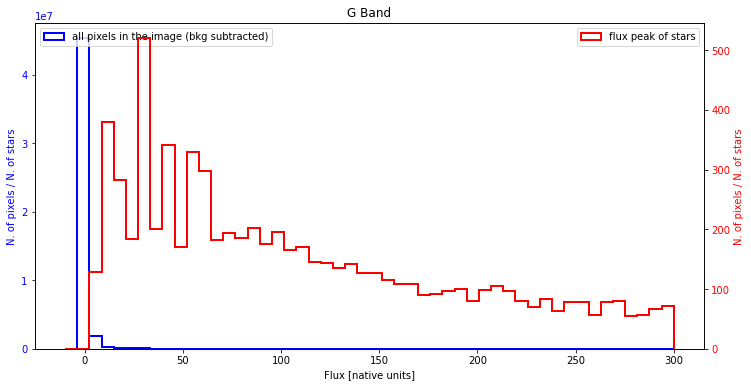

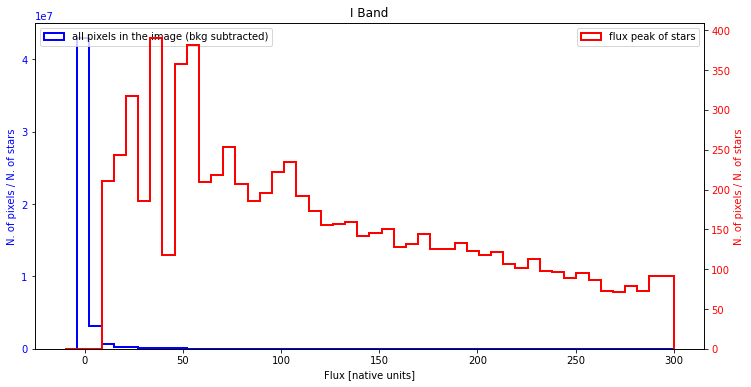

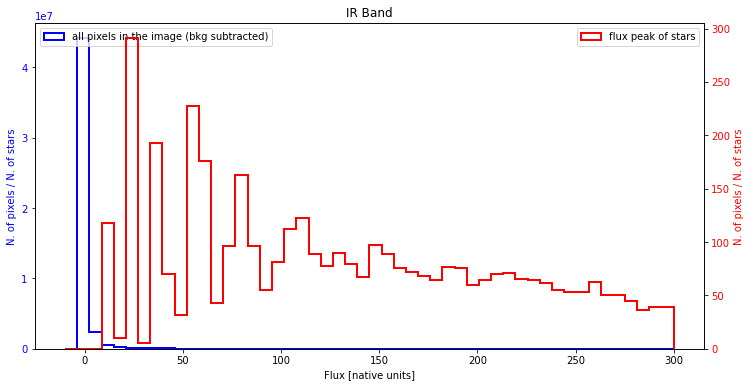

In [29]:
# Calculate flux and plot
g_flux, g_fluxerr = find_flux(g_clean, g_objects, g_bkg, title='G Band')
i_flux, i_fluxerr = find_flux(i_clean, i_objects, i_bkg, title='I Band')
IR_flux, IR_fluxerr = find_flux(IR_clean, IR_objects, IR_bkg, title='IR Band')

# Cutouts with User Defined Normalisation

Now we will create a pdf with cutouts of a few galaxies displayed in the g, i and IR band as well as in a stacked image of the three. Before we can do this we need to 1) create a stacked image and 2) create a function that can properly normalise the images so the features are clear, since I don't know how to open the .pyc image provided.

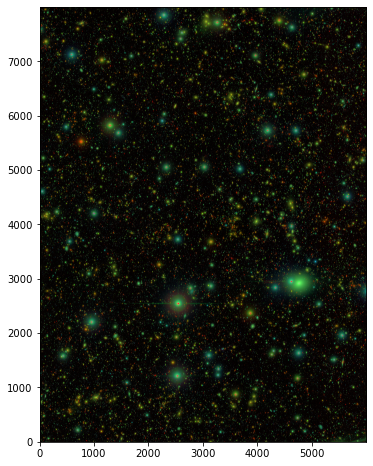

In [30]:
# Creating the stacked image
image = make_lupton_rgb(IR_img, i_img, g_img, Q=20, stretch=10) #order of color is RGB

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(image, origin='lower')

plt.show()

In [31]:
def get_xyr(index, objects):
    
    x = objects['x'][index]
    y = objects['y'][index]
    r = ((objects['xmax'][index]-objects['xmin'][index])/2 + (objects['ymax'][index]-objects['ymin'][index])/2 )/2
    
    xrange = ( int(np.floor(x-5*r)), int(np.floor(x+5*r)) )
    yrange = ( int(np.floor(y-5*r)), int(np.floor(y+5*r)) )

    return x, y, r, xrange, yrange

In [32]:
def make_circle(x,y,r,ax,color='red'):
    c = Circle(xy=(x,y), radius=r)
    c.set_facecolor('none')
    c.set_edgecolor(color)
    ax.add_artist(c)

In [34]:
# Filename
filename = 'Saved_Results/Cutouts_LinearColorbar.pdf'

# List of galaxy names, here just indexed
gal_list = ['GAL' + str(i+1) for i in range(5)]
filters = ['G Band', 'I Band', 'IR Band', 'Stacked Image']

# List of chosen indices (stars) to plot
IR_index = [110, 120, 130, 410, 500]

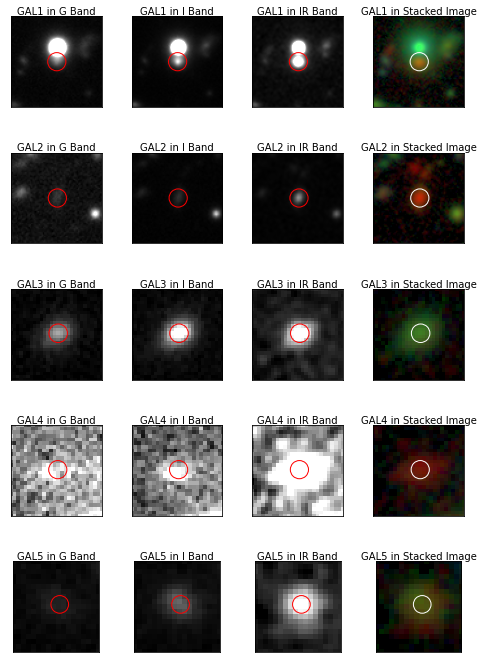

In [35]:
# Create a pdf object
pdfOut = PdfPages(filename)

# Define subplots to fill one page: includes `nr` rows and `nc` columns
nr = 5; nc = 4
figsize = (8.3, 11.7)
fig, ax = plt.subplots(nrows=nr, ncols=nc, figsize=figsize, gridspec_kw={'wspace': 0.2, 'hspace': 0.5})

# 1ST PAGE ---------------------------------------------------------------------------------------------
# Loop over galaxies on first page
for i, idn in enumerate(gal_list):
    
    # When all nr rows are done
    if i>0 and i%nr==0:
        
        # Save the figure into the pdf, and close
        fig.savefig(pdfOut, format='pdf') 
        plt.close(fig) 
    
    # Get star coordinates
    x, y, r, xrange, yrange = get_xyr(IR_index[i], IR_objects)
    
    # Set general titles for all subplots, and remove ticks from axis
    for j in range(nc):
        ax[i%nr,j].set_title('{} in {}'.format(gal_list[i],filters[j]),fontsize=10, pad=-10.)
        ax[i%nr,j].get_xaxis().set_visible(False)
        ax[i%nr,j].get_yaxis().set_visible(False)
        
    ####  For each row, we plot in each column subplot ####
    # G Band ----
    g_normal = simple_norm(g_clean[xrange[0]:xrange[1],yrange[0]:yrange[1]], stretch='linear', percent=99.5)
    ax[i,0].imshow(g_clean, cmap='gray', origin='lower', norm=g_normal)
    ax[i,0].set_xlim(xrange[0],xrange[1])
    ax[i,0].set_ylim(yrange[0],yrange[1])
    make_circle(x,y,r,ax[i,0])
        
    # I Band ----
    i_normal = simple_norm(i_clean[xrange[0]:xrange[1],yrange[0]:yrange[1]], stretch='linear', percent=99.5)
    ax[i,1].imshow(i_clean, cmap='gray', origin='lower', norm=i_normal)
    ax[i,1].set_xlim(xrange[0],xrange[1])
    ax[i,1].set_ylim(yrange[0],yrange[1])
    make_circle(x,y,r,ax[i,1])
        
    # IR Band ----
    IR_normal = simple_norm(IR_clean[xrange[0]:xrange[1],yrange[0]:yrange[1]], stretch='linear', percent=99.5)
    ax[i,2].imshow(IR_clean, cmap='gray', origin='lower', norm=IR_normal)
    ax[i,2].set_xlim(xrange[0],xrange[1])
    ax[i,2].set_ylim(yrange[0],yrange[1])
    make_circle(x,y,r,ax[i,2])
        
    # Stacked ----
    ax[i,3].imshow(image, cmap='gray', origin='lower')
    ax[i,3].set_xlim(xrange[0],xrange[1])
    ax[i,3].set_ylim(yrange[0],yrange[1])
    make_circle(x,y,r,ax[i,3], color='white')

        
fig.savefig(pdfOut,format='pdf')
pdfOut.close()

**notes on first try of making one cutout**

This will sometimes yield an error, since we need enough pixels around the object to be able to display it. Something weirds happens at 60??? Its all black except in the stacked image.

why do the images get grainy when choosing in the i band instead of the ir band.

sometimes it seems part of the images are missing? small white patches looks like nan.

also what is the best choice for normalising? sqrt or linear? another one?

I guess i should also convert to sky coordinates?

Choose in the i band because it is in the middle? Or perhaps do a page of choosing in each filter?

# Cutouts with zscale normalisation

In [36]:
import zscale # The file has been placed in the same directory, so easy to access

In [37]:
# Filename
filename = 'Saved_Results/Cutouts_ZscaleColorbar.pdf'

# List of galaxy names, here just indexed
gal_list = ['GAL' + str(i+1) for i in range(5)]
filters = ['G Band', 'I Band', 'IR Band', 'Stacked Image']

# List of chosen indices (stars) to plot
IR_index = [110, 120, 130, 410, 500]

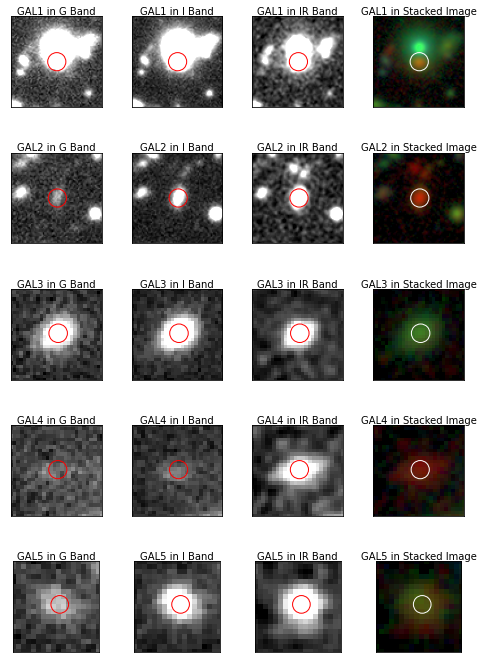

In [38]:
# Create a pdf object
pdfOut = PdfPages(filename)

# Define subplots to fill one page: includes `nr` rows and `nc` columns
nr = 5; nc = 4
figsize = (8.3, 11.7)
fig, ax = plt.subplots(nrows=nr, ncols=nc, figsize=figsize, gridspec_kw={'wspace': 0.2, 'hspace': 0.5})

# 1ST PAGE ---------------------------------------------------------------------------------------------
# Loop over galaxies on first page
for i, idn in enumerate(gal_list):
    
    # When all nr rows are done
    if i>0 and i%nr==0:
        
        # Save the figure into the pdf, and close
        fig.savefig(pdfOut, format='pdf') 
        plt.close(fig) 
    
    # Get star coordinates
    x, y, r, xrange, yrange = get_xyr(IR_index[i], IR_objects)
    
    # Set general titles for all subplots, and remove ticks from axis
    for j in range(nc):
        ax[i%nr,j].set_title('{} in {}'.format(gal_list[i],filters[j]),fontsize=10, pad=-10.)
        ax[i%nr,j].get_xaxis().set_visible(False)
        ax[i%nr,j].get_yaxis().set_visible(False)
        
    ####  For each row, we plot in each column subplot ####
    # G Band ----
    mapp = ax[i,0].imshow(g_clean, cmap='gray', origin='lower', norm=g_normal)
    zrange = zscale.zscale(g_clean)    
    mapp.set_clim(zrange)
    ax[i,0].set_xlim(xrange[0],xrange[1])
    ax[i,0].set_ylim(yrange[0],yrange[1])
    make_circle(x,y,r,ax[i,0])
        
    # I Band ----
    mapp2 = ax[i,1].imshow(i_clean, cmap='gray', origin='lower', norm=i_normal)
    zrange2 = zscale.zscale(i_clean)
    mapp2.set_clim(zrange2)
    ax[i,1].set_xlim(xrange[0],xrange[1])
    ax[i,1].set_ylim(yrange[0],yrange[1])
    make_circle(x,y,r,ax[i,1])
        
    # IR Band ----
    mapp3 = ax[i,2].imshow(IR_clean, cmap='gray', origin='lower', norm=IR_normal)
    zrange3 = zscale.zscale(IR_clean)
    mapp3.set_clim(zrange3)
    ax[i,2].set_xlim(xrange[0],xrange[1])
    ax[i,2].set_ylim(yrange[0],yrange[1])
    make_circle(x,y,r,ax[i,2])
        
    # Stacked ----
    ax[i,3].imshow(image, cmap='gray', origin='lower')
    ax[i,3].set_xlim(xrange[0],xrange[1])
    ax[i,3].set_ylim(yrange[0],yrange[1])
    make_circle(x,y,r,ax[i,3], color='white')

        
fig.savefig(pdfOut,format='pdf')
pdfOut.close()

# Comparing fluxes to the COSMOS Catalogue

First we need to select a few objects from the objects we found with SEP. We need to save the x and y coordiantes (pixels) of the objects, as well as the 2'' aperture flux (to be able to compare with the 2'' apertures from the COSMOS catalogue). 

We will now use WCS's ``pixel_to_world`` function to transform the coordinates into sky coordinates, so we can find matching sky coordinates in the COSMOS catalogue, by using Iary's ``match_cat`` function. When we have the indices of the object from each file, we can compare their fluxes and see if they are alike.

This can be done for each of the images we have analysed thus far, and we can even compare the fluxes of a objects in each of the band and not only with the COSMOS catalogue. Notice that the COSMOS catalogue contains files for each of the bands we have analysed of our images, so naturally we will compare the fluxes of our found objects with SEP to the corresponding band flux in the catalogue.

In [39]:
# Lets close figures to not trash the computer
plt.close('all')

In [40]:
# Chose a few objects (lets select objects that are bright - 
# okay I dont know if these are bright we can adjust later) 
mask = (i_objects['flux'] > 15) & (i_objects['flux'] < 300)
pix_coord = list( zip(i_objects['x'][mask], i_objects['y'][mask]))

# Find the radius in pixels, we want two arcsecond diameter, with each pixel being 0,15 arcseconds
r_2arcsec = 1 / 0.15

# Find fluxes for the ten first objects in the selection of objects
flux, fluxerr, flag = sep.sum_circle(i_clean, i_objects['x'][mask], i_objects['y'][mask], r_2arcsec, err=i_bkg.rms(), gain=1.0)

In [41]:
# Now we need to convert the coordinates into sky coordinates, we will do this with WCS
f = fits.open('Resources/HSC_i_SSP_PDR2_19_07_19_v3_CANDELS.fits')
w = WCS(f[0].header)
img_sky = w.pixel_to_world(i_objects['x'][mask], i_objects['y'][mask]) #image sky coordinates

In [42]:
img_sky

<SkyCoord (ICRS): (ra, dec) in deg
    [(150.02856109, 2.03436693), (149.99140122, 2.0343666 ),
     (150.00256874, 2.03442429), ..., (150.01425245, 2.3672508 ),
     (150.01432615, 2.36753643), (150.00375297, 2.36760422)]>

Since we already have the coordinates in a SkyCoord class (from which I cant figure out how to extract the arrays), we will adjust the match_cat function a little (the part where it converts ra and dec into a SkyCoord class - this is already done so will be skipped)

In [43]:
# Now lets save all the sky coordinates and 2'' fluxes from COSMOS for the given objects
from astropy import table
tab = table.Table.read("Resources/COSMOS2020_CLASSIC_v1.5_formatted.fits",format="fits")

In [44]:
# Extracting coordinates: Notice alpha_j2000 is the "ra" coordinate, and delta_j2000 is the "dec" coordinate
cosmo_coord = [ tab['ALPHA_J2000'], tab['DELTA_J2000'] ]
cosmo_flux = tab['HSC_i_FLUX_APER2'] #in microjansky

In [45]:
#Sky matching function (adjusted so my_skycoord should be a SkyCoord class)

def match_cat(my_skycoord, cat_coord, r=0.6):

    # SkyCoord eats numbers with units.
    # This function assumes input coordinates are in decimal degree
    import astropy.units as u
    cat_skycoord = SkyCoord(ra = cat_coord[0], dec = cat_coord[1], unit='deg') #i had to change this a little
    
    idx, d2d, _ = match_coordinates_sky(my_skycoord, cat_skycoord)
    max_sep = r*u.arcsec
    sep_limit = d2d < max_sep
    #sep_limit not only the mask for selecting objects within the 2nd sample, but by itself can be used to select in the 1st sample.
    return sep_limit, idx[sep_limit]

In [46]:
# Get indices of matching objects
my_idx, cosmo_idx = match_cat(img_sky, cosmo_coord)

# And find the flux
my_flux = flux[my_idx]
cat_flux = cosmo_flux[cosmo_idx]

In [47]:
# Now lets convert flux into magnitude so we can compare them

# Define zeropoint magnitudes for converting
HSC_zeromag = 31.4 #from native image units
COSMO_zeromag = 23.9 #from micro jansky

# Finding magnitudes
my_mag = -2.5*np.log10(my_flux) + HSC_zeromag
cat_mag = -2.5*np.log10(cat_flux) + COSMO_zeromag

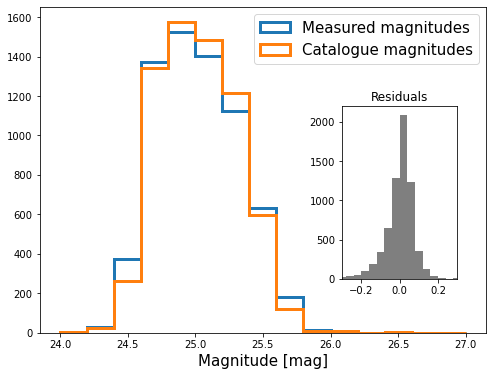

In [71]:
# Displaying magnitudes as histogram
fig, ax = plt.subplots(figsize=(8,6))

# Plot distributions
ax.hist(my_mag, bins=15, histtype='step', range=(24,27), linewidth=3, label='Measured magnitudes')
ax.hist(cat_mag, bins=15, histtype='step', range=(24,27), linewidth=3, label='Catalogue magnitudes')
ax.legend(prop={'size':15})
ax.set_xlabel('Magnitude [mag]', fontsize=15)

# Make residual plot within plot
ax2 = fig.add_axes([0.65,0.25,0.2,0.4])
ax2.set_title('Residuals', fontsize=12)
ax2.hist(my_mag-cat_mag, bins=1, range=(-1,1), label='SEP mag - COSMOS mag', color='k', alpha=0.5)
ax2.set(xlim=(-0.3,0.3), ylim=(0,2200))

plt.show()

In orange are the magnitudes I calculated from the flux displayed in the catalogue. In blue, are the magnitudes I have found myself by using SEP and this entire notebook almost. They look pretty consistent so that is good.

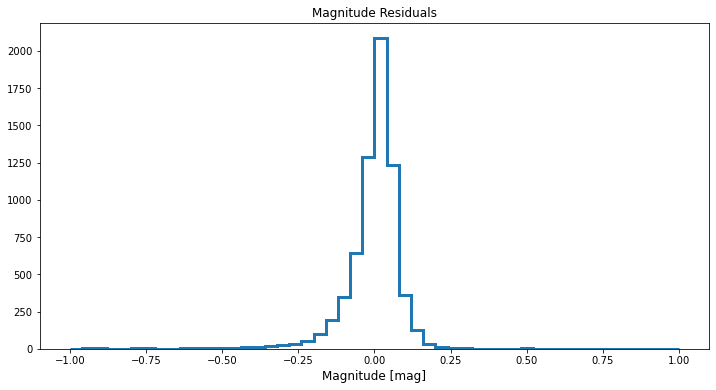

In [53]:
# Lets show the residuals as well (the difference)
fig, ax = plt.subplots(figsize=(12,6))

ax.hist(my_mag-cat_mag, bins=50, range=(-1,1), histtype='step', linewidth=3, label='SEP mag - COSMOS mag')
ax.set_title('Magnitude Residuals')
ax.set_xlabel('Magnitude [mag]', fontsize=12)
plt.show()

As desired, the residuals look pretty normal distributed around 0.

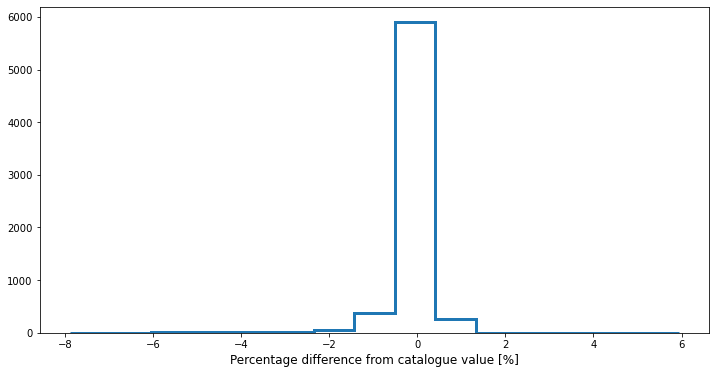

In [77]:
# Lets display the percentage difference from the catalogue value and fit a gaussian
perc_off = (my_mag-cat_mag)/cat_mag * 100

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(perc_off, bins=15, histtype='step', linewidth=3)
ax.set_xlabel('Percentage difference from catalogue value [%]', fontsize=12)
plt.show()



The percentage difference is around up to 2% which is still a little more than expected.

Lets explore what the reason might be behind the errors. First we check whether the coordinates actually match (MISSING). We could also look at objects with very different fluxes and plot the magnitude difference as a function of log(flux), to see if the discrepancy is larger at certain fluxes.

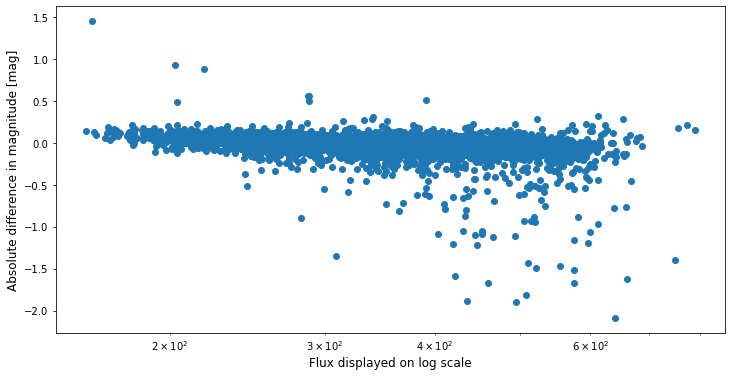

In [78]:
fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(my_flux, my_mag-cat_mag, label='Residuals with measured magnitudes')
ax.set_xscale('log')

ax.set_xlabel('Flux displayed on log scale', fontsize=12)
ax.set_ylabel('Absolute difference in magnitude [mag]', fontsize=12)

plt.show()

It seem there is a bigger problem with larger fluxes than smaller fluxes, although the plot hints at a trend it is not very convincing.

# Exporting files with obejcts obtained etc. to use in another notebook

This notebook is getting quite long, so I will try to extract the most important objects and arrays so we can use them in another script without having to running the search for sky objects everytime. For this we will use pickle.

From this notebook the important objects to save are:
- g_objects, i_objects and IR_objects, which contain the important information about the found objects.
- g_clean, i_clean and IR_clean, which are the images with the background subtracted.
- g_bkg.rms(), i_bkg.rms() and IR_bkg.rms(), which are the errors on the background matrix. Notice we don't need to return the background itself, since this is subtracted from the image in g_clean, i_clean and IR_clean.

In [88]:
import pickle

In [90]:
# Save objects ---------------------------------------------------------------------
with open("Saved_Resources/g_objects.pkl", "wb") as file:
    pickle.dump(g_objects, file)
    
with open("Saved_Resources/i_objects.pkl", "wb") as file:
    pickle.dump(i_objects, file)
    
with open("Saved_Resources/IR_objects.pkl", "wb") as file:
    pickle.dump(IR_objects, file)

# Save cleaned images --------------------------------------------------------------
with open("Saved_Resources/g_clean.pkl", "wb") as file:
    pickle.dump(g_clean, file)
    
with open("Saved_Resources/i_clean.pkl", "wb") as file:
    pickle.dump(i_clean, file)
    
with open("Saved_Resources/IR_clean.pkl", "wb") as file:
    pickle.dump(IR_clean, file)
    
# Save background rms --------------------------------------------------------------
with open("Saved_Resources/g_bkg_rms.pkl", "wb") as file:
    pickle.dump(g_bkg.rms(), file)
    
with open("Saved_Resources/i_bkg_rms.pkl", "wb") as file:
    pickle.dump(i_bkg.rms(), file)
    
with open("Saved_Resources/IR_bkg_rms.pkl", "wb") as file:
    pickle.dump(IR_bkg.rms(), file)